<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B7%D0%BD%D0%B8_%D0%9F%D0%B0%D1%80%D0%BA%D0%B8%D0%BD%D1%81%D0%BE%D0%BD%D0%B0_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_OpenCV%2C_%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B8_%D1%82%D0%B5%D1%81%D1%82%D0%B0_%D1%81%D0%BF%D0%B8%D1%80%D0%B0%D0%BB%D0%B8_%D0%B2%D0%BE%D0%BB%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение болезни Паркинсона с помощью OpenCV, компьютерного зрения и теста спирали / волны

# Parkinson's Disease Detection with OpenCV, Computer Vision, and Helix / Wave Test 

В этом уроке вы узнаете, как использовать OpenCV и машинное обучение для автоматического обнаружения болезни Паркинсона в нарисованных от руки изображениях спиралей и волн.
Для обнаружения болезни Паркинсона было выбрано именно машинное обучение, а не глубокое, так как с глубоким обучением вероятность переобучения гораздо выше. В качестве модели будет использован алгоритм классификации Random forest.
Мы изучим наш набор данных рисунков, собранных у пациентов с болезнью Паркинсона и без нее.

После просмотра набора данных мы используем дескриптор изображения HOG для количественной оценки входных изображений, а затем обучим классификатор случайного леса на извлеченных признаках.

In this tutorial, you will learn how to use OpenCV and machine learning to automatically detect Parkinson's in hand-drawn images of spirals and waves.
Machine learning was chosen to detect Parkinson's disease, not deep learning, since with deep learning the likelihood of overfitting is much higher. The Random forest classification algorithm will be used as a model.
We will examine our dataset of drawings collected from patients with and without Parkinson's disease.

After viewing the dataset, we use the HOG image descriptor to quantify the input images and then train the random forest classifier on the extracted features.

### Загрузка файлов 
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_11.Detecting_Parkinson_Disease.zip
!unzip -qq Lesson_11.Detecting_Parkinson_Disease.zip
%cd /content/Lesson_11.Detecting_Parkinson_Disease/detect-parkinsons

--2022-02-17 18:31:31--  http://dataudt.ru/datasets/cv/Lesson_11.Detecting_Parkinson_Disease.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21745884 (21M) [application/zip]
Saving to: ‘Lesson_11.Detecting_Parkinson_Disease.zip’

Lesson_11.Detecting 100%[===================>]  20.74M  10.8MB/s    in 1.9s    

2022-02-17 18:31:33 (10.8 MB/s) - ‘Lesson_11.Detecting_Parkinson_Disease.zip’ saved [21745884/21745884]

/content/Lesson_11.Detecting_Parkinson_Disease/detect-parkinsons


### Импорт библиотек  
### Import Packages

In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

### Функция отображения изображений в Jupyter Notebooks и Google Colab
### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(15, 15))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Реализация кода детектора Паркинсона 
### Implementing the Parkinson’s detector script

In [4]:
def quantify_image(image):
    # вычисляем гистограмму вектора признаков ориентированных градиентов для
	# входного изображения
	# compute the histogram of oriented gradients feature vector for
	# the input image
	features = feature.hog(image, orientations=9,
		pixels_per_cell=(10, 10), cells_per_block=(2, 2),
		transform_sqrt=True, block_norm="L1")

    # возвращаем вектор признаков
	# return the feature vector
	return features

In [5]:
def load_split(path):
    # берем список изображений во входном каталоге, затем инициализируем
	# список данных (т.е. изображений) и меток классов
	# grab the list of images in the input directory, then initialize
	# the list of data (i.e., images) and class labels
	imagePaths = list(paths.list_images(path))
	data = []
	labels = []

    # проходим циклом через все пути к изображениям
	# loop over the image paths
	for imagePath in imagePaths:
        # извлекаем метку класса из имени файла
		# extract the class label from the filename
		label = imagePath.split(os.path.sep)[-2]

        # загружаем исходное изображение, преобразовываем его в оттенки серого и изменяем его размер
		# до 200x200 пикселей, игнорируя соотношение сторон
		# load the input image, convert it to grayscale, and resize
		# it to 200x200 pixels, ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image = cv2.resize(image, (200, 200))

        # обрабатываем изображения так, чтобы рисунок выглядел белым
		# на черном фоне
		# threshold the image such that the drawing appears as white
		# on a black background
		image = cv2.threshold(image, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # оцениваем изображение
		# quantify the image
		features = quantify_image(image)

        # обновляем списки данных и меток соответственно
		# update the data and labels lists, respectively
		data.append(features)
		labels.append(label)

    # возвращаем данные и метки
	# return the data and labels
	return (np.array(data), np.array(labels))

In [10]:


# явно укажем аргументы необходимые для работы
# dataset - путь к входному набору данных
# trials - количество испытаний для запуска

# у нас есть два датасета: изображения со спиралями и с волнами
# чтобы добиться лучшего результата - сначала попробуем обучить сеть на одном датасете, а затем на другом

# explicitly specify the arguments needed to work
# dataset - path to input dataset
# trials - number of trials to run

# сначала попробуем изображения с волнами
#args = {
#	"dataset": "dataset/wave",
 #   "trials": 5
#}

# закомментируйте вышеупомянутый код, после его выполнения, а затем раскомментируйте код ниже
# и запустите его
# этот код нужен для загрузки датасета с изображениями спиралей
# comment the above once it's done and then uncomment the below
# and run the rest of the following code
# this code is needed to load a dataset with spiral images
args = {
 	"dataset": "dataset/spiral",
     "trials": 5
}

In [7]:
# определяем путь к обучайщей и тестовой выборкам
# define the path to the training and testing directories
trainingPath = os.path.sep.join([args["dataset"], "training"])
testingPath = os.path.sep.join([args["dataset"], "testing"])

# загружаем обучающую и тестовую выборки
# loading the training and testing data
print("[INFO] loading data...")
(trainX, trainY) = load_split(trainingPath)
(testX, testY) = load_split(testingPath)

# кодируем метки как целые числа
# encode the labels as integers
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

# инициализируем наш словарь попыток
# initialize our trials dictionary
trials = {}

[INFO] loading data...


In [11]:
# проходимся через все количество запускаемых испытаний
# loop over the number of trials to run
for i in range(0, args["trials"]):
    # обучаем модель
	# train the model
	print("[INFO] training model {} of {}...".format(i + 1,
		args["trials"]))
	model = RandomForestClassifier(n_estimators=100)
	model.fit(trainX, trainY)

    # делаем предсказания на основе тестовых данных и инициализируем словарь
	# для хранения вычисленных метрик
	# make predictions on the testing data and initialize a dictionary
	# to store our computed metrics
	predictions = model.predict(testX)
	metrics = {}

    # вычисляем матрицу ошибок и используем ее для получения
	# точности, чувствительности и специфичности
	# compute the confusion matrix and and use it to derive the raw
	# accuracy, sensitivity, and specificity
	cm = confusion_matrix(testY, predictions).flatten()
	(tn, fp, fn, tp) = cm
	metrics["acc"] = (tp + tn) / float(cm.sum())
	metrics["sensitivity"] = tp / float(tp + fn)
	metrics["specificity"] = tn / float(tn + fp)

    # перебираем все метрики
	# loop over the metrics
	for (k, v) in metrics.items():
        # обновляем словарь попыток со списком значений для
		# текущей метрики
		# update the trials dictionary with the list of values for
		# the current metric
		l = trials.get(k, [])
		l.append(v)
		trials[k] = l

[INFO] training model 1 of 5...
[INFO] training model 2 of 5...
[INFO] training model 3 of 5...
[INFO] training model 4 of 5...
[INFO] training model 5 of 5...


In [12]:
# перебираем все метрики
# loop over our metrics
for metric in ("acc", "sensitivity", "specificity"):
    # получаем список значений для текущей метрики, затем вычисляем
	# среднее и стандартное отклонение
	# grab the list of values for the current metric, then compute
	# the mean and standard deviation
	values = trials[metric]
	mean = np.mean(values)
	std = np.std(values)

    # показываем вычисленные метрики для статистики
	# show the computed metrics for the statistic
	print(metric)
	print("=" * len(metric))
	print("u={:.4f}, o={:.4f}".format(mean, std))
	print("")

acc
===
u=0.7067, o=0.0512

sensitivity
u=0.6867, o=0.0427

specificity
u=0.7267, o=0.0814



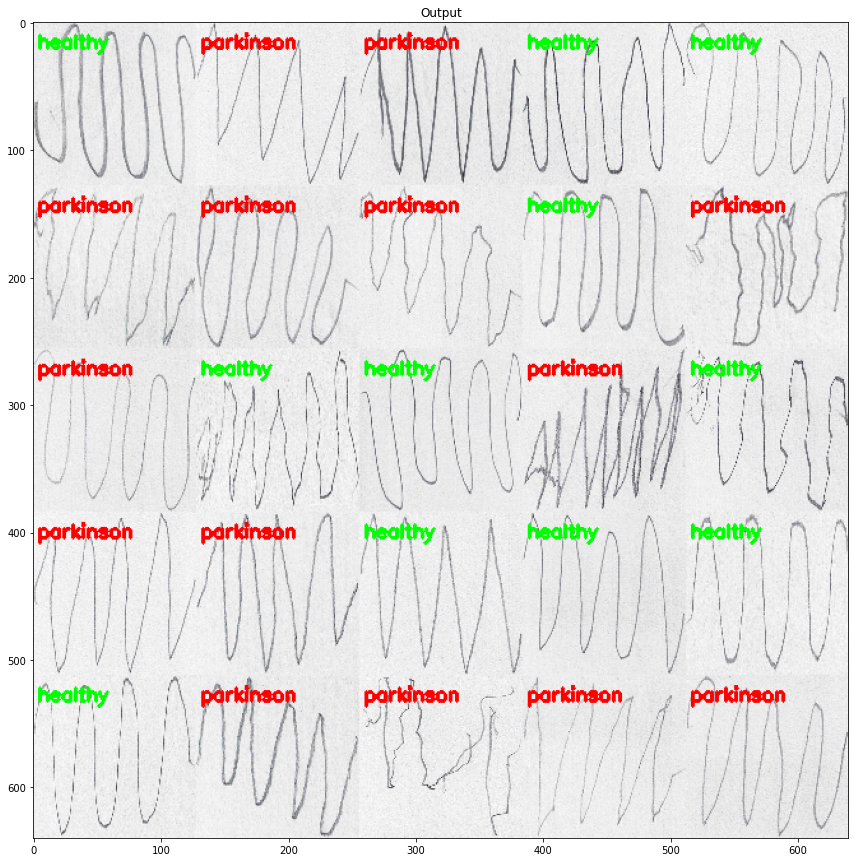

In [13]:
# случайным образом выбираем несколько изображений, а затем инициализируем выходные изображения для коллажа
# randomly select a few images and then initialize the output images
# for the montage
testingPaths = list(paths.list_images(testingPath))
idxs = np.arange(0, len(testingPaths))
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

# проходим циклом по тестовым образцам
# loop over the testing samples
for i in idxs:
    # загружаем тестовое изображение, копируем его и изменяем размер
	# load the testing image, clone it, and resize it
	image = cv2.imread(testingPaths[i])
	output = image.copy()
	output = cv2.resize(output, (128, 128))

    # предварительно обработываем изображение так же, как мы делали ранее
	# pre-process the image in the same manner we did earlier
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = cv2.resize(image, (200, 200))
	image = cv2.threshold(image, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # оцениваем изображение и делаем предсказания на основе извлеченных
	# признаков, используем обученный случайный лес
	# quantify the image and make predictions based on the extracted
	# features using the last trained Random Forest
	features = quantify_image(image)
	preds = model.predict([features])
	label = le.inverse_transform(preds)[0]

    # рисуем цветную метку класса на выходном изображении и добавляем ее в
	# набор выходных изображений
	# draw the colored class label on the output image and add it to
	# the set of output images
	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		color, 2)
	images.append(output)

# создаем коллаж из кватратов размером 128x128 с 5 строками и 5 столбцами
# create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

# отображаем выходной коллаж
# show the output montage
plt_imshow("Output", montage)